# Continuous Authentication
Continuous Authentication is an interesting area of computer security that has the potential to be an addition to passwords, but act as a form of continuous password, using biometrics


In [5]:
import preprocess

subject = 4

# Preprocessing the data is easy, we can pass in a specific subject to get the data for.
# This data is shuffled automatically, however if you don't want it shuffled, you can 
# pass shuffled=False to the binary classify function
X_train, X_test, y_train, y_test = preprocess.binary_classify(subject=subject, save=False)

# When looking at the head, we will notice two values, 0 and 1 (if the data is shuffled, 
# otherwise, you'll just see 1's). The 0 represents imposer user data, while 1 represents 
# a genuine user row.
y_train.head()

18180    0
30460    0
67276    0
48893    1
39421    1
Name: ID, dtype: int64

# Running models
There are two main types of models I'm working with here, *classifiers* and *regressors*. Classifiers are here to do binary classification, is the mouse event presented to the model a genuine user action or an imposter user action. Regressors, on the other hand, assign somewhat a probability to the event.


In [6]:
from sklearn.neighbors import KNeighborsClassifier

# We can create the classifier
classifier = KNeighborsClassifier()
# Fit our training data to the classifier
classifier.fit(X_train, y_train)
# And create predictions from that classifier
y_cls_pred = classifier.predict(X_test)

In [7]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)
y_reg_pred = regressor.predict(X_test)

# Validating the models

Accuracy: 94.8368%
Precision: 91.9850%
Recall: 98.1080%
F1: 94.9479%


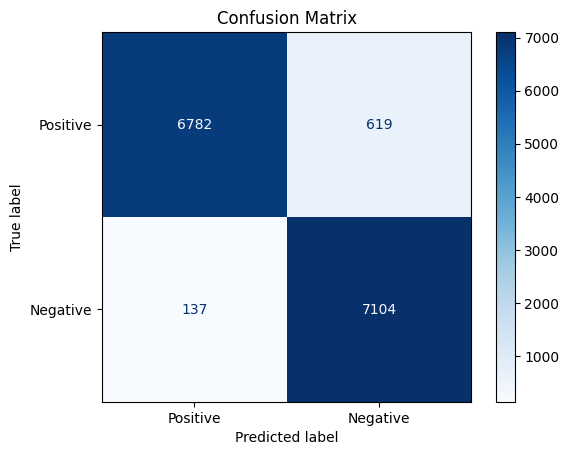

Calculating trust score: 100%|██████████| 14642/14642 [00:00<00:00, 3072493.45 Predictions/s]

Trust score calculations: C = 95.4 violations = 611


In [15]:
import validation
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

validation.calculate_metric_scores(y_test, y_cls_pred)

disp = ConfusionMatrixDisplay.from_estimator(
    classifier,
    X_test,
    y_test,
    display_labels=["Positive", "Negative"],
    cmap=plt.cm.Blues,
).ax_.set_title(f"KNN Confusion Matrix ({subject = })")

plt.show()

C, violations = validation.calculate_trust_score(y_reg_pred)
print(f"Trust score calculations: {C = } {violations = }")